In [56]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('default')
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap, TSNE
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed, Embedding, GlobalAveragePooling1D
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stopwords = set(stopwords_list.decode().splitlines()) 
import os
os.environ["PATH"] += os.pathsep + "C:\\Users\\tiagoft1\\Graphviz\\bin"

# Pré-processamento

In [21]:
df = pd.read_csv('../datasets/IMDB Dataset.csv')
reviews = list(df['review'])

labels = np.array([list(df['sentiment'])]).T
ohe = OneHotEncoder()
y = ohe.fit_transform(labels).toarray()

In [7]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

In [10]:
print(sequences[0])

[27, 4, 1, 79, 45, 12, 100, 147, 39, 307, 398, 474, 26, 33, 23, 203, 14, 11, 6, 621, 48, 596, 16, 68, 7, 7, 1, 86, 148, 12, 68, 42, 13, 92, 2, 134, 4, 570, 60, 268, 8, 203, 36, 1, 661, 139, 68, 11, 6, 21, 3, 119, 15, 1, 38, 11, 119, 54, 16, 5, 376, 38, 570, 92, 6, 8, 1, 360, 356, 4, 1, 661, 7, 7, 9, 6, 433, 14, 12, 6, 1, 358, 5, 1, 9, 20, 538, 32, 4, 1, 117, 29, 1, 25, 2, 391, 34, 6, 21, 299, 20, 1, 538, 6, 344, 5, 106, 2, 51, 34, 327, 2, 23, 110, 225, 243, 7, 7, 10, 58, 131, 1, 280, 4, 1, 119, 6, 693, 5, 1, 192, 12, 9, 269, 117, 79, 276, 589, 834, 180, 15, 834, 834, 887, 149, 954, 183, 1, 86, 398, 10, 123, 210, 68, 14, 34, 9, 13, 10, 413, 131, 10, 13, 15, 9, 18, 14, 10, 287, 51, 10, 3, 15, 2, 189, 5, 1, 299, 4, 570, 21, 39, 570, 18, 26, 41, 15, 3, 504, 20, 642, 2, 76, 243, 16, 9, 69, 651, 710, 109, 662, 82, 693, 5, 65, 574, 4, 920, 38, 559, 147, 22, 200, 426, 16, 48, 6, 805, 43, 22, 67, 76, 8, 16, 125, 486]


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded = pad_sequences(sequences,maxlen=200)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2)

# Uma classificação por palavra!

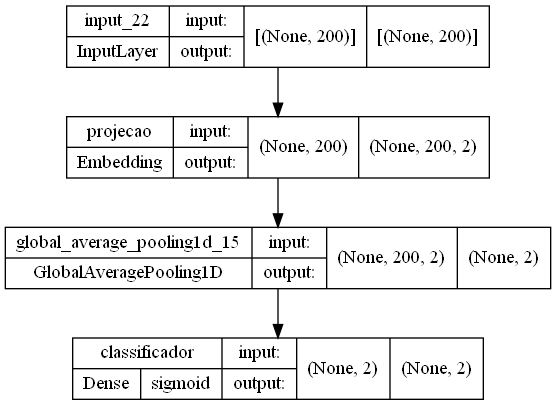

In [123]:
def rede_neural_classificar_por_palavra(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = GlobalAveragePooling1D()(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_classificar_por_palavra(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [124]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 2s 1ms/step - loss: 0.2417 - val_loss: 0.2278
Epoch 2/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.2099 - val_loss: 0.1931
Epoch 3/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1786 - val_loss: 0.1665
Epoch 4/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1561 - val_loss: 0.1482
Epoch 5/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1403 - val_loss: 0.1354
Epoch 6/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1293 - val_loss: 0.1263
Epoch 7/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1214 - val_loss: 0.1199
Epoch 8/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1154 - val_loss: 0.1149
Epoch 9/500
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1108 - val_loss: 0.1113
Epoch 10/500
1000/1000 [==============================] - 1s 1ms/step - l

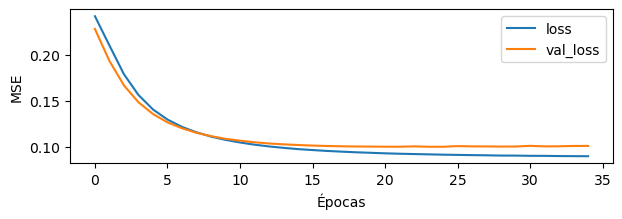

In [125]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [126]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      5044
    positive       0.85      0.88      0.86      4956

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



## Analisando layer de Embedding

In [ ]:
w = rede_neural.get_layer('projecao').get_weights()

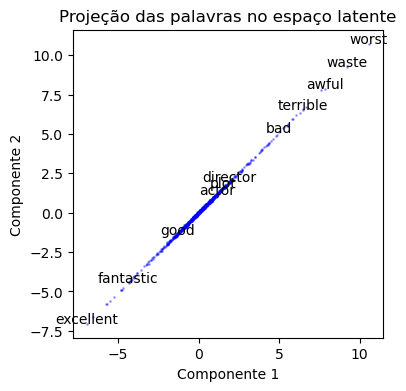

In [ ]:
# Visualização 2: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

#proj = TSNE(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

## Combinação com redes recorrentes

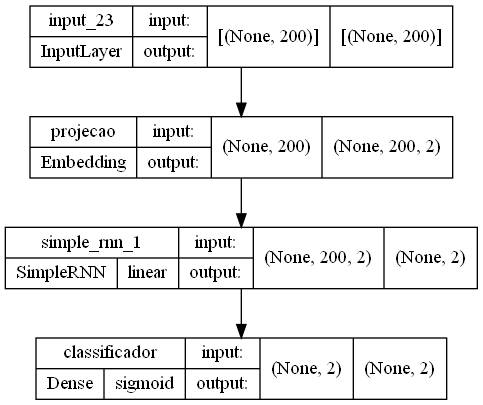

In [127]:
from keras.layers import SimpleRNN, GRU
def rede_neural_com_RNN(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(1000, 2, name='projecao')(x)
  x = SimpleRNN(2, activation='linear')(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_com_RNN(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [128]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 30s 29ms/step - loss: 0.2494 - val_loss: 0.2478
Epoch 2/500
1000/1000 [==============================] - 28s 28ms/step - loss: 0.2422 - val_loss: 0.2431
Epoch 3/500
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2341 - val_loss: 0.2427
Epoch 4/500
1000/1000 [==============================] - 28s 28ms/step - loss: 0.2296 - val_loss: 0.2432
Epoch 5/500
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2270 - val_loss: 0.2434
Epoch 6/500
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2253 - val_loss: 0.2438
Epoch 7/500
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2241 - val_loss: 0.2444
Epoch 8/500
1000/1000 [==============================] - 28s 28ms/step - loss: 0.2230 - val_loss: 0.2435
Epoch 9/500
1000/1000 [==============================] - 28s 28ms/step - loss: 0.2220 - val_loss: 0.2426
Epoch 10/500
1000/1000 [==============================]

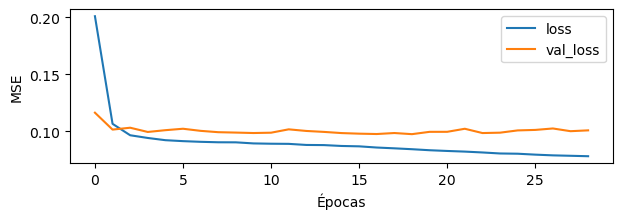

In [94]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [95]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      5044
    positive       0.87      0.85      0.86      4956

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



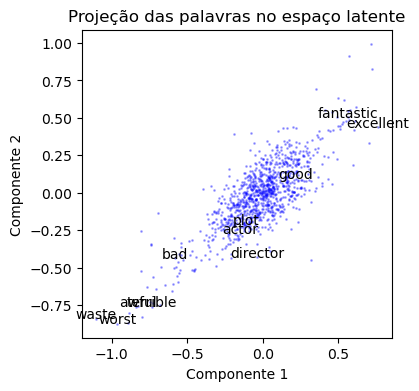

In [96]:
# Visualização 2: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

#proj = TSNE(n_components=2, perplexity=5)
#v = proj.fit_transform(v_)
v = v_

plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.3, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()

# Usar embeddings pré-treinados (GloVe)

In [107]:
f = open("./datasets/glove.6B.100d.txt", encoding="utf8")
embeddings_index = dict()
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        continue
f.close()


In [108]:
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


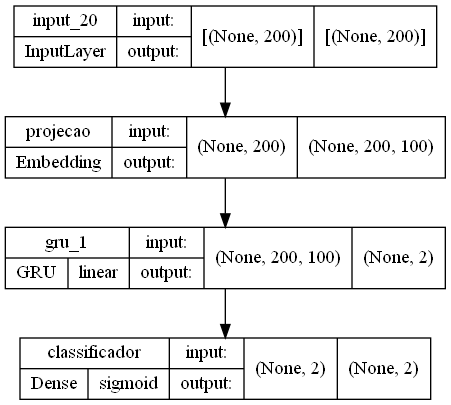

In [111]:
from keras.layers import SimpleRNN, GRU
def rede_neural_com_Glove(input_dims, n_dims_out):
  input_layer = Input(shape=(input_dims,))
  x = input_layer
  x = Embedding(len(word_index) + 1, 100, name='projecao', weights=[embedding_matrix], trainable=False)(x)
  x = GRU(2, activation='linear')(x)
  y = Dense(2, activation='sigmoid', name='classificador')(x)
  return Model(input_layer, y)

rede_neural = rede_neural_com_Glove(200, 2)
rede_neural.compile(optimizer='adam', loss='mse')
plot_model(rede_neural, show_shapes=True, show_layer_activations=True)

In [112]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
history = rede_neural.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=es)

Epoch 1/500
1000/1000 [==============================] - 39s 33ms/step - loss: 0.1966 - val_loss: 0.1430
Epoch 2/500
1000/1000 [==============================] - 32s 32ms/step - loss: 0.1344 - val_loss: 0.1339
Epoch 3/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.1284 - val_loss: 0.1299
Epoch 4/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.1253 - val_loss: 0.1267
Epoch 5/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.1231 - val_loss: 0.1257
Epoch 6/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.1215 - val_loss: 0.1250
Epoch 7/500
1000/1000 [==============================] - 33s 33ms/step - loss: 0.1202 - val_loss: 0.1231
Epoch 8/500
1000/1000 [==============================] - 31s 31ms/step - loss: 0.1195 - val_loss: 0.1225
Epoch 9/500
1000/1000 [==============================] - 32s 32ms/step - loss: 0.1181 - val_loss: 0.1213
Epoch 10/500
1000/1000 [==============================]

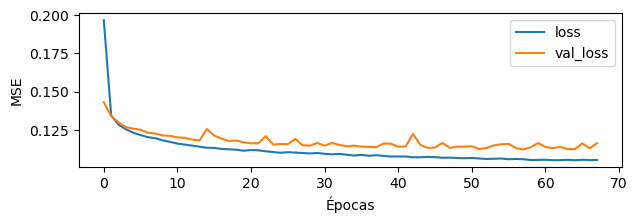

In [116]:
plt.figure(figsize=(7,2))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [117]:
y_est = rede_neural.predict(X_test)
print(classification_report(ohe.inverse_transform(y_test), ohe.inverse_transform(y_est)))

              precision    recall  f1-score   support

    negative       0.86      0.83      0.84      5044
    positive       0.83      0.86      0.85      4956

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



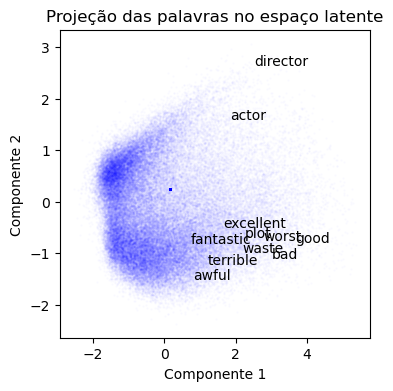

In [120]:
# Visualização 2: onde foi parar cada palavra?
v_ = rede_neural.get_layer('projecao').get_weights()[0]

proj = PCA(n_components=2)
v = proj.fit_transform(v_)


plt.figure(figsize=(4,4))
plt.scatter(v[:,0], v[:,1], s=1, alpha=0.01, c='b')
for s in ["director", "actor", "bad", "good", "excellent", "plot", "worst", "terrible", "waste", "awful", "fantastic"]:
    _n = tokenizer.texts_to_sequences([[s]])[0][0]
    plt.text(v[_n,0], v[_n,1], s, ha='center')
plt.title('Projeção das palavras no espaço latente')
plt.ylabel('Componente 2')
plt.xlabel('Componente 1')
#plt.xlim([-20,20])
#plt.ylim([-20,20])
plt.show()